# Data Science For Biology 2025 Final Project

# Protein Sequence Mutation

## Libraries & Packages

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from scipy.stats import pearsonr

## Data Loading

In [122]:
data = pd.read_csv("./gcn4-orthologs.csv")
data = data.rename(columns={data.columns[0]: "tile_id"})
data.head()

,tile_id,DNAseq,ADseq,numreads_per_AD_7AGFP_AAS,Activity_7AGFP_AAS,numreads_per_AD_8AmCh_AAS,Activity_8AmCh_AAS,numreads_per_AD_9ARatio_AAS,Activity_9ARatio_AAS,numreads_per_AD_10BRatio_AAS,...,Activity_BYS4_BioRepAverage,Stdev_BYS4_BioReps,Activity_SCglucose,Start,Recovered,Activity_SCgalactose,Activity_P3promoter,Activity_P14promoter,Activity_P15promoter,Activity_P3promoterMig1TFBSremoved
0,0,AAAAATTCTAGATTTGTTTCTTTGATGCAAGGATTCTCTGATGGTT...,KNSRFVSLMQGFSDGSKDIIDNEVREVGDFSVNKPPQADD,NaN,NaN,NaN,NaN,NaN,NaN,3151.0,...,NaN,NaN,11666.48682,341,True,97250.68362,NaN,11149.49032,NaN,8040.343648
1,1,AAAAATTCTCCATCTGGTTTGGCTCATTCTTCTGTTTCTGGTGTTG...,KNSPSGLAHSSVSGVGKSRRRKGPLPPITVQDPSDKTAIK,942.0,709.606092,367.0,2921.917252,601.0,22242.74698,6909.0,...,21968.05843,5849.143385,21968.05843,146,True,15516.96245,14570.13217,16872.28649,11555.08411,10255.296840
2,2,AAACAAAATTCTCAAGTTGATCAATCTCCATTGTTGCCAGAAGAAG...,KQNSQVDQSPLLPEEELEVSEHLRRRRSGTATSPPAGGVR,NaN,NaN,NaN,NaN,NaN,NaN,6577.0,...,NaN,NaN,21203.02478,326,True,0.00000,18274.98241,15702.60901,18303.29201,17265.783330
3,3,AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATG...,KQRATPLTPVVPESDDPVALKRARNTEAARRSRARKLERM,357.0,1039.469842,342.0,1089.428196,450.0,74251.36241,NaN,...,NaN,NaN,47244.41248,246,True,92844.00000,NaN,NaN,NaN,84807.518160
4,4,AAACAAAGATCTATTCCATTGTCTCCAATTGTTCCAGAATCTTCTG...,KQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRM,539.0,1081.980998,627.0,622.131501,586.0,58872.95132,128.0,...,95093.69451,13292.686710,95093.69451,211,True,76399.62949,NaN,125056.17980,129302.35080,100360.735500


In [123]:
len(data.iloc[0, 2])

40

In [124]:
num_rows = data.shape[0]
num_cols = data.shape[1]

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 19038
Number of columns: 35


### Data Exploration
First, we will start by analyzing the data for missing values

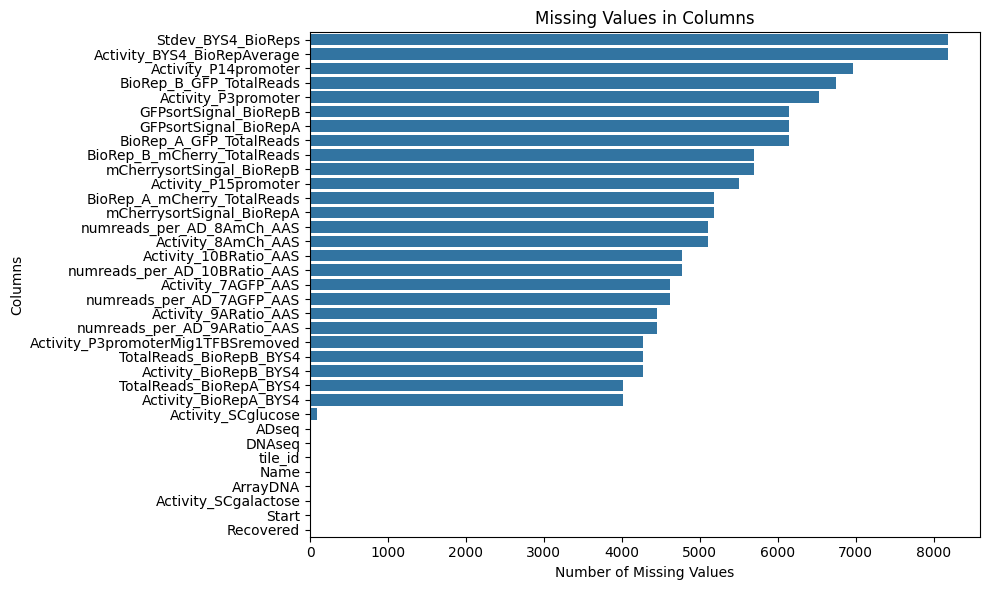

In [125]:
# Bar chart for missing values hprizontally
missing_values = data.isnull().sum()
#missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.values, y=missing_values.index, orient="h")
plt.xlabel("Number of Missing Values")
plt.ylabel("Columns")
plt.title("Missing Values in Columns")
plt.tight_layout()
#plt.savefig("GCN4_missing_values.png")
plt.show()

There are quite a lot of zeroes but here we recall that the doc explicitly mentions that the tile with `NaN` activities really means that they were not measured at all. So, intuitively, it dos not make sense to treat these values as  zero-activity values since this would mislead our model into thinking that these tiles are just functionally silent.

As per the final project warmup, it will be good to only consider the rows with a higher sequencing reads since those with very low sequencing reads can be introduce noise when we begin modelling. To this end, we set a introduce a new hyperparameter `read_threshold` that will allow us to filter the dataset for rows with reads greater than or equal to the arbitrarily specified `read_threshold`

In [126]:
read_threshold = 1000 # threshold for read count

df_filtered = data[(data['TotalReads_BioRepA_BYS4'] >= read_threshold) & (data['TotalReads_BioRepB_BYS4'] >= read_threshold)]
print(f"Number of rows before filtering: {num_rows}")
print(f"Number of rows removed: {num_rows - df_filtered.shape[0]}")
print(f"Number of rows after filtering: {df_filtered.shape[0]}")

Number of rows before filtering: 19038
Number of rows removed: 9985
Number of rows after filtering: 9053


For a baseline model, we will use `Activity_SCglucose` as a baseline activity measurement since I believe the project doc mentioned it is the most well-characterized condition in the dataset. Since the project doc says that zeroes represent unmeasured quantities, I will drop these rows to prevent additional noise in our data

In [127]:
activity_col = "Activity_SCglucose"
df_filtered = df_filtered[df_filtered[activity_col] > 0]

print(f"Number of rows after filtering for non-zero {activity_col}: {df_filtered.shape[0]}")

Number of rows after filtering for non-zero Activity_SCglucose: 9053


In [129]:
df_with_seq = df_filtered.copy()

## Feature Engineering
Section to add new features inferred from existing columns like net charge

In [70]:
# FEATURES

# variables I need glovally
AA_LIST = 'ACDEFGHIKLMNPQRSTVWY'
AA_COLS = [f"AA_{aa}" for aa in AA_LIST]

# I use Kyte-Doolittle scale for hydrophobicity hereee CHECK WITH PROF STALLER
# https://www.rbvi.ucsf.edu/chimera/docs/UsersGuide/midas/hydrophob.html
KD_HYDROPHOBICITY = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
    'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
    'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

# i use the tuple here for naming the motifs
MOTIFS = [
    ("W..LF", "W..LF"),
    ("WFYL_WFYL", "[WFYL]..[WFYL][WFYL]"),
    ("WFL_WFL", "[WFL]..[WFL][WFL]"),
    ("DE_WFY", "[DE][WFY]"),
    ("DE_WF", "[DE][WF]"),
    ("DE_L", "[DE][L]"),
    ("DE_x_WFY", "[DE].[WFY]"),
    ("DE_xx_WFY", "[DE]..[WFY]"),
    ("FF", "FF"),
    ("F_F", "F.F"),
    ("F__F", "F..F"),
    ("FY_5x_FY", "[FY].....[FY]"),
    ("SP", "SP"),
    ("WFYL_3x_WFYL", "[WFYL]...[WFYL][WFYL]")
]

# FUNCTIONS TO CALC

def amino_acid_count(sequence: str) -> dict[str, int]:
    c = Counter(sequence)
    return {f"AA_{aa}": c.get(aa, 0) for aa in AA_LIST}

def net_charge(seq: str) -> int:
    charge_map = {"K": 1, "R": 1, "D": -1, "E": -1}
    return sum(charge_map.get(a, 0) for a in seq)

def hydrophobicity(sequence: str) -> float:
    total_hydrophobicity = sum(KD_HYDROPHOBICITY[aa] for aa in sequence if aa in KD_HYDROPHOBICITY)
    return total_hydrophobicity

def motif_counts_dict(seq: str) -> dict[str, int]:
    return {name: len(re.findall(pat, seq)) for name, pat in MOTIFS}

# APPLY DA FEATURESSSS
def add_sequence_features(df: pd.DataFrame, seq_col: str = "ADseq") -> pd.DataFrame:
    # AA composition
    aa_expanded = df[seq_col].apply(amino_acid_count).apply(pd.Series)
    
    # Motif counts
    motif_expanded = df[seq_col].apply(motif_counts_dict).apply(pd.Series)

    # Scalar features
    df["NetCharge"] = df[seq_col].apply(net_charge)
    df["Hydrophobicity"] = df[seq_col].apply(hydrophobicity)
    
    # Sequence length
    df["Length"] = df[seq_col].str.len()

    # Combine everything
    result_df = pd.concat([df, aa_expanded, motif_expanded], axis=1)

    return result_df

In [71]:
# Apply features to the filtered DataFrame
df_filtered = add_sequence_features(df_filtered)
df_filtered.iloc[:, 35:]

,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,AA_G,AA_H,...,DE_WF,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL
1,6,-34.0,40,2,0,2,0,0,4,1,...,0,0,0,0,0,0,0,0,1,0
7,1,-24.2,40,3,1,2,1,1,3,3,...,0,0,0,0,0,0,0,0,0,0
8,2,-36.7,40,2,0,3,0,0,2,1,...,0,0,1,0,0,0,0,0,2,0
12,-4,-13.8,40,6,0,4,2,4,3,0,...,1,3,0,1,0,0,1,0,1,0
18,6,-24.4,40,5,0,0,1,2,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19021,-1,-33.9,40,2,0,3,1,4,0,4,...,1,0,0,1,0,0,1,0,1,0
19030,-6,19.9,40,3,1,6,0,3,1,0,...,0,1,0,1,0,0,0,0,0,0
19033,-7,-42.3,40,1,0,5,3,2,2,1,...,0,1,1,1,0,0,0,0,1,0
19036,2,27.8,40,5,2,1,0,2,3,2,...,0,0,0,0,0,0,0,0,1,0


## Feature Selection
FOr now I'm gonna use all of them

In [72]:
X = df_filtered.iloc[:, 35:]
y = df_filtered[activity_col]


# now i structure the final prep data
df = pd.concat([X, y], axis=1)

assert df.isna().sum().sum() == 0, "Features contain NaNs"

# quick sanity check for missing values
print("Missing values in final data:")
print(df.isnull().sum())

Missing values in final data:
NetCharge             0
Hydrophobicity        0
Length                0
AA_A                  0
AA_C                  0
AA_D                  0
AA_E                  0
AA_F                  0
AA_G                  0
AA_H                  0
AA_I                  0
AA_K                  0
AA_L                  0
AA_M                  0
AA_N                  0
AA_P                  0
AA_Q                  0
AA_R                  0
AA_S                  0
AA_T                  0
AA_V                  0
AA_W                  0
AA_Y                  0
W..LF                 0
WFYL_WFYL             0
WFL_WFL               0
DE_WFY                0
DE_WF                 0
DE_L                  0
DE_x_WFY              0
DE_xx_WFY             0
FF                    0
F_F                   0
F__F                  0
FY_5x_FY              0
SP                    0
WFYL_3x_WFYL          0
Activity_SCglucose    0
dtype: int64


In [73]:
df.head()

,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,AA_G,AA_H,...,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL,Activity_SCglucose
1,6,-34.0,40,2,0,2,0,0,4,1,...,0,0,0,0,0,0,0,1,0,21968.05843
7,1,-24.2,40,3,1,2,1,1,3,3,...,0,0,0,0,0,0,0,0,0,70876.84864
8,2,-36.7,40,2,0,3,0,0,2,1,...,0,1,0,0,0,0,0,2,0,16850.74599
12,-4,-13.8,40,6,0,4,2,4,3,0,...,3,0,1,0,0,1,0,1,0,226681.83670
18,6,-24.4,40,5,0,0,1,2,0,1,...,0,0,0,0,0,0,0,1,0,33491.53797


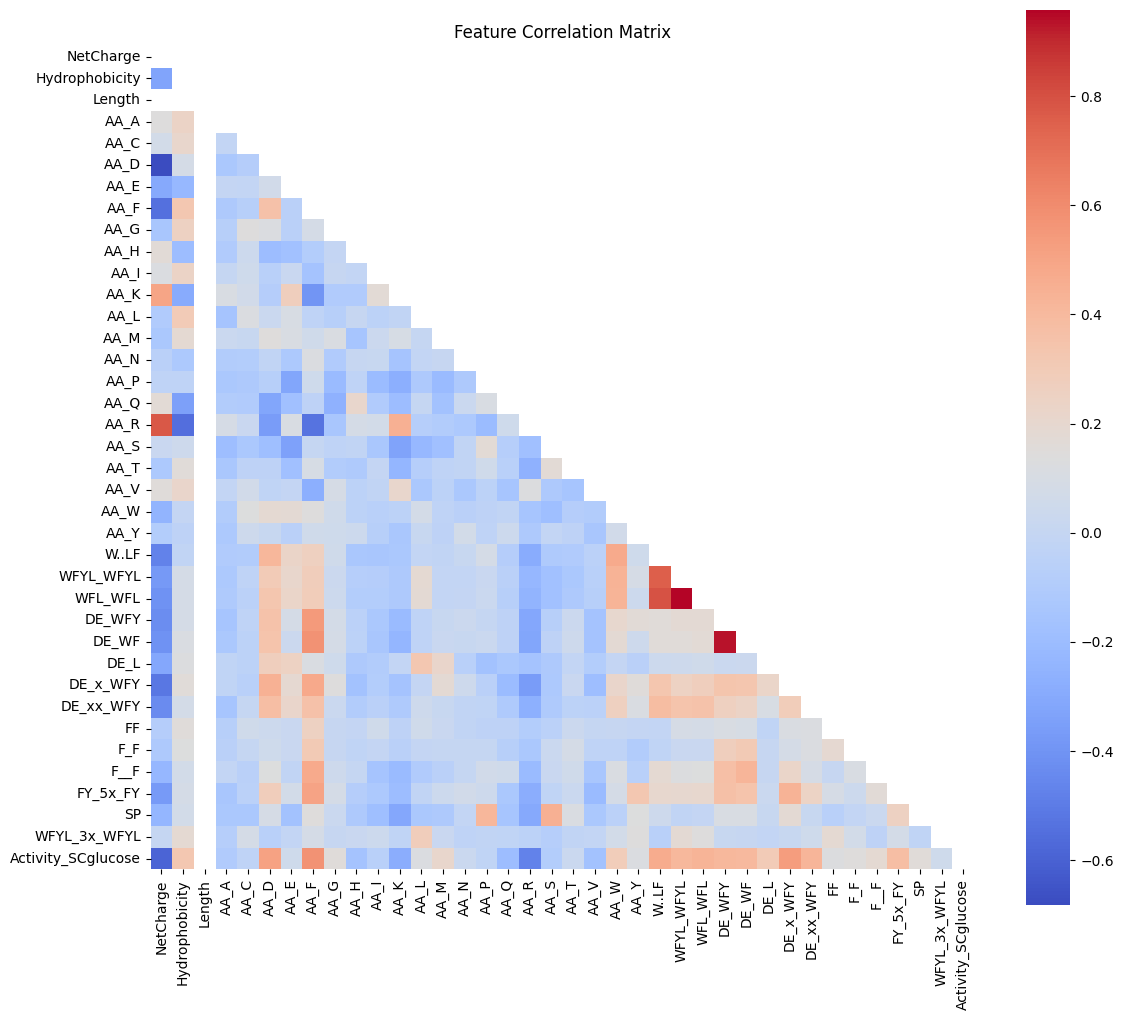

In [74]:
# Check correlation matrix
plt.figure(figsize=(12, 12))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=False, fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Feature Correlation Matrix")
plt.tight_layout()
#plt.savefig("GCN4_correlation_matrix.png")
plt.show()

## Baseline Model Development

In typical ML fashion, we begin by splitting our data into a train and test set. Also, since the target values are much higher than our engineered features, we will have to scale it appropriately. I'm just going to use Z-Score normalization which is implemented out of the box via sklearn's `StandardScaler` class.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Cool, now that we have train and test set, we're going to build multiple baseline models, i will try lasso and ridge regression

In [76]:
ridge_reg = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
ridge_reg.fit(X_train, y_train)
ridge_reg_y_pred = ridge_reg.predict(X_test)

#  just print for now
print("Ridge Regression Results:")
print(f"R^2: {r2_score(y_test, ridge_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, ridge_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, ridge_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, ridge_reg_y_pred)[0]}")

Ridge Regression Results:
R^2: 0.6201281103997202
MAE: 28987.144163384466
RMSE: 39767.08032290962
Pearson Correlation: 0.7876414833027815


In [77]:
lasso_reg = make_pipeline(StandardScaler(), Lasso(alpha=1.0, max_iter=100000))
lasso_reg.fit(X_train, y_train)
lasso_reg_y_pred = lasso_reg.predict(X_test)

print("Lasso Regression Results:")
print(f"R^2: {r2_score(y_test, lasso_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, lasso_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, lasso_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, lasso_reg_y_pred)[0]}")

Lasso Regression Results:
R^2: 0.6201318526495319
MAE: 28986.773807345686
RMSE: 39766.88444277287
Pearson Correlation: 0.7876439144538867


In [78]:
linear_reg = make_pipeline(StandardScaler(), LinearRegression())
linear_reg.fit(X_train, y_train)
linear_reg_y_pred = linear_reg.predict(X_test)

print("Linear Regression Results:")
print(f"R^2: {r2_score(y_test, linear_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, linear_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, linear_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, linear_reg_y_pred)[0]}")

Linear Regression Results:
R^2: 0.6195473827129548
MAE: 29117.094968717207
RMSE: 39797.46559986865
Pearson Correlation: 0.7874523256507424


In [79]:
random_forest_reg = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
random_forest_reg.fit(X_train, y_train)
random_forest_y_pred = random_forest_reg.predict(X_test)

print("Logistic Regression Results:")
print(f"R^2: {r2_score(y_test, random_forest_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, random_forest_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, random_forest_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, random_forest_y_pred)[0]}")

Logistic Regression Results:
R^2: 0.7961507641413464
MAE: 20054.764553828776
RMSE: 29131.28699844031
Pearson Correlation: 0.8929759233179536


### Baseline Model Evaluation

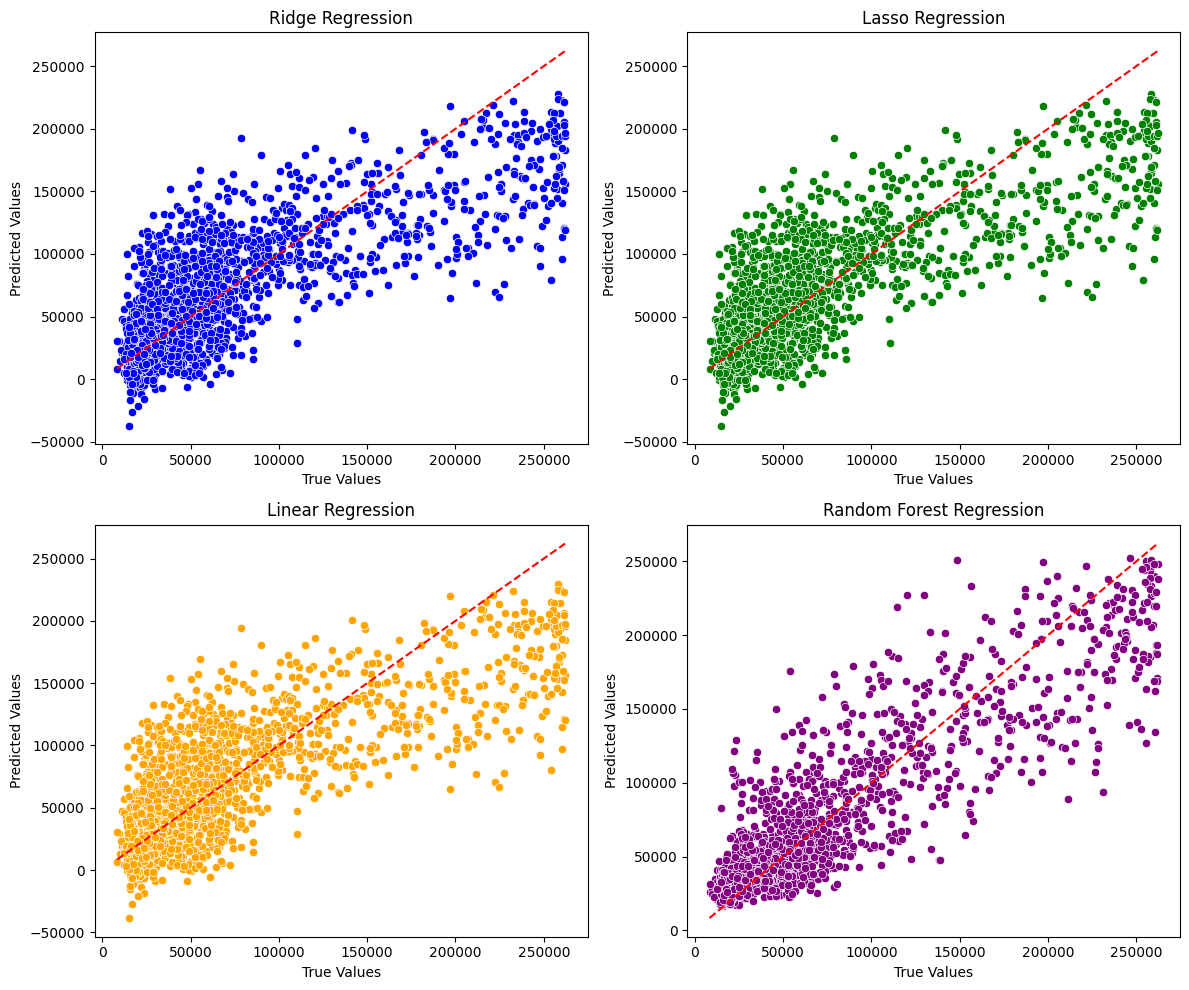

In [80]:
# Make subplots for each model
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Ridge Regression
sns.scatterplot(x=y_test, y=ridge_reg_y_pred, ax=axes[0], color='blue')
axes[0].set_title("Ridge Regression")
axes[0].set_xlabel("True Values")
axes[0].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[0], color='red', linestyle='--')

# Lasso Regression
sns.scatterplot(x=y_test, y=lasso_reg_y_pred, ax=axes[1], color='green')
axes[1].set_title("Lasso Regression")
axes[1].set_xlabel("True Values")
axes[1].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[1], color='red', linestyle='--')

# Linear Regression
sns.scatterplot(x=y_test, y=linear_reg_y_pred, ax=axes[2], color='orange')
axes[2].set_title("Linear Regression")
axes[2].set_xlabel("True Values")
axes[2].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[2], color='red', linestyle='--')

# Random Forest Regression
sns.scatterplot(x=y_test, y=random_forest_y_pred, ax=axes[3], color='purple')
axes[3].set_title("Random Forest Regression")
axes[3].set_xlabel("True Values")
axes[3].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[3], color='red', linestyle='--')

plt.tight_layout()
plt.show()


In [81]:
# Make df of results
results = {
    "Model": ["Ridge", "Lasso", "Linear", "Random Forest"],
    "R^2": [
        r2_score(y_test, ridge_reg_y_pred),
        r2_score(y_test, lasso_reg_y_pred),
        r2_score(y_test, linear_reg_y_pred),
        r2_score(y_test, random_forest_y_pred)
    ],
    "MAE": [
        mean_absolute_error(y_test, ridge_reg_y_pred),
        mean_absolute_error(y_test, lasso_reg_y_pred),
        mean_absolute_error(y_test, linear_reg_y_pred),
        mean_absolute_error(y_test, random_forest_y_pred)
    ],
    "RMSE": [
        root_mean_squared_error(y_test, ridge_reg_y_pred),
        root_mean_squared_error(y_test, lasso_reg_y_pred),
        root_mean_squared_error(y_test, linear_reg_y_pred),
        root_mean_squared_error(y_test, random_forest_y_pred)
    ],
    "Pearson Correlation": [
        pearsonr(y_test, ridge_reg_y_pred)[0],
        pearsonr(y_test, lasso_reg_y_pred)[0],
        pearsonr(y_test, linear_reg_y_pred)[0],
        pearsonr(y_test, random_forest_y_pred)[0]
    ]
}
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="R^2", ascending=False).reset_index(drop=True)   
results_df.head()

,Model,R^2,MAE,RMSE,Pearson Correlation
0,Random Forest,0.796151,20054.764554,29131.286998,0.892976
1,Lasso,0.620132,28986.773807,39766.884443,0.787644
2,Ridge,0.620128,28987.144163,39767.080323,0.787641
3,Linear,0.619547,29117.094969,39797.465600,0.787452


## Feature Importances Analysis

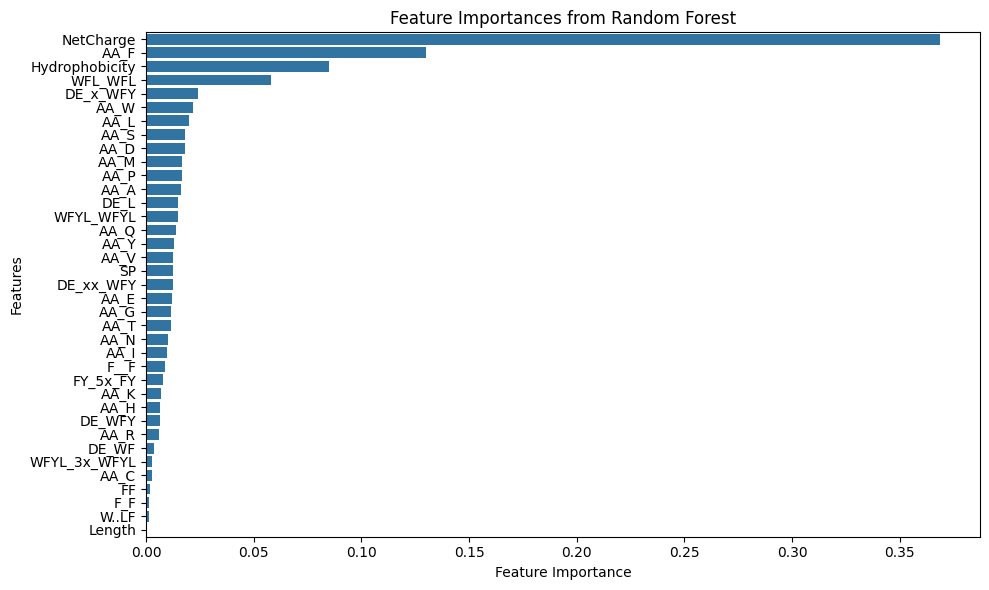

In [82]:
feature_importances = random_forest_reg.named_steps['randomforestregressor'].feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importances, y=sorted_feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
#plt.savefig("GCN4_feature_importances.png")
plt.show()

## Protein Language Model Embedding Generation

https://github.com/evolutionaryscale/esm/issues/2

# DNA Sequence Mutation

In [92]:
from transformers import EsmModel, EsmConfig

# Initializing a ESM facebook/esm-1b style configuration
configuration = EsmConfig(vocab_size=33)

# Initializing a model from the configuration
model = EsmModel(configuration)

# Accessing the model configuration
configuration = model.config

In [119]:
data.columns

Index(['tile_id', 'DNAseq', 'ADseq', 'numreads_per_AD_7AGFP_AAS',
       'Activity_7AGFP_AAS', 'numreads_per_AD_8AmCh_AAS', 'Activity_8AmCh_AAS',
       'numreads_per_AD_9ARatio_AAS', 'Activity_9ARatio_AAS',
       'numreads_per_AD_10BRatio_AAS', 'Activity_10BRatio_AAS', 'Name',
       'ArrayDNA', 'Activity_BioRepA_BYS4', 'Activity_BioRepB_BYS4',
       'TotalReads_BioRepA_BYS4', 'TotalReads_BioRepB_BYS4',
       'BioRep_A_GFP_TotalReads', 'GFPsortSignal_BioRepA',
       'BioRep_B_GFP_TotalReads', 'GFPsortSignal_BioRepB',
       'BioRep_A_mCherry_TotalReads', 'mCherrysortSignal_BioRepA',
       'BioRep_B_mCherry_TotalReads', 'mCherrysortSingal_BioRepB',
       'Activity_BYS4_BioRepAverage', 'Stdev_BYS4_BioReps',
       'Activity_SCglucose', 'Start', 'Recovered', 'Activity_SCgalactose',
       'Activity_P3promoter', 'Activity_P14promoter', 'Activity_P15promoter',
       'Activity_P3promoterMig1TFBSremoved'],
      dtype='object')

In [130]:
from transformers import AutoTokenizer, AutoModel
import torch
from dotenv import load_dotenv
import os
import numpy as np
from tqdm import tqdm

# Load the .env file
load_dotenv()
hf_token = os.getenv("HF_TOKEN")

# Load model and tokenizer once
model_id = "facebook/esm1b_t33_650M_UR50S"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
model = AutoModel.from_pretrained(model_id, token=hf_token)
model.eval()

def generate_embedding(sequence):
    """Generate pooled ESM embedding for a protein sequence."""
    input_ids = tokenizer(sequence, return_tensors="pt").input_ids
    attention_mask = torch.ones_like(input_ids)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        sequence_embeddings = outputs.last_hidden_state.squeeze()

    # Remove special tokens [CLS], [EOS]
    sequence_embeddings = sequence_embeddings[1:-1]

    # Mean-pool across residues
    pooled_embedding = sequence_embeddings.mean(dim=0)  # shape: (hidden_size,)
    return pooled_embedding.cpu().numpy()

def save_embeddings_to_npz(data, sequence_column, save_path):
    """Generate embeddings for all sequences and save into a single NPZ file."""
    all_embeddings = []

    for sequence in tqdm(data[sequence_column], desc="Generating embeddings"):
        embedding = generate_embedding(sequence)
        all_embeddings.append(embedding)

    all_embeddings = np.stack(all_embeddings)  # Shape: (num_sequences, hidden_dim)

    np.savez_compressed(save_path, embeddings=all_embeddings)
    print(f"Saved {len(all_embeddings)} embeddings to {save_path}")

# Example usage:
save_embeddings_to_npz(df_with_seq, sequence_column="ADseq", save_path="./esm2_embeddings.npz")


/home/qamil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm1b_t33_650M_UR50S and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating embeddings:   1%|          | 96/9053 [00:42<1:06:51,  2.23it/s]


KeyboardInterrupt: 

In [116]:
sequence_embeddings = sequence_embeddings.numpy()
clean_embeddings = sequence_embeddings[1:-1]
clean_embeddings.shape

(40, 1280)

In [117]:
pooled_embedding = clean_embeddings.mean(axis=0)
pooled_embedding.shape

(1280,)